In [1]:
from pathlib import Path
from pylook.units import units
import pylook.calc as lc
from pylook.io import read_binary
import numpy as np
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
def read_hdf(fileName):
    data = pd.DataFrame()
    for chanName in h5.File(fileName, "r")['mechData'].keys():
        data[chanName] = h5.File(fileName, "r")['mechData'][chanName]
    return data

In [3]:
def pl(y, y2=None, idx1=0, idx2=-1, ylog=False, y2log=False):
    %matplotlib widget
    fig, axs = plt.subplots(1, 1, figsize=(12, 5), sharex=True)
    axs.plot(data[y][idx1:idx2], color='blue')
    if ylog == True:
        axs.set_yscale('log')
    plt.show()

    if y2 != None:
        %matplotlib widget
        fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        axs[0].plot(data[y][idx1:idx2], color='blue')
        axs[1].plot(data[y2][idx1:idx2], color='red')
        if ylog == True:
            axs[0].set_yscale('log')
        if y2log == True:
            axs[1].set_yscale('log')
        
        plt.show()

In [4]:
data = read_hdf("p5720_py.h5")

In [5]:
data['Time'] = np.cumsum(data['Time']/1e4)
data['time'] = data.pop('Time')

data['norm disp'] = data.pop('Hor DCDT')
data['norm stress'] = data.pop('Hor LOAD')
data['pc disp'] = data.pop('Pc Disp')
data['pc press'] = data.pop('Pc LOAD')
data['ppa disp'] = data.pop('Ppa Disp')
data['ppa press'] = data.pop('Ppa LOAD')
data['ppb press'] = data.pop('Ppb LOAD')
data['ppb disp'] = data.pop('Ppb Disp')
data['int disp'] = data.pop('Int DCDT')

In [6]:
# CALIBRATIONS FOR DISPLACEMENTS AND STRESSES
#---------------------------------------------------------------------------------------

# HORIZONTAL DISPLACEMENT
# high gain, short rod: 0.657956387503886 mm/V
h_disp_calib = (20/2**24)  * 0.657956387503886 * 1000 #um/mm 
data['norm disp'] = data['norm disp'] * h_disp_calib

# HORIZONTAL INTERNAL DISPLACEMENT
# high gain: 0.415958632711548 mm/V
Hint_disp_calib = (20/2**24)  * 0.415958632711548 * 1000 #um/mm 
data['int disp'] = data['int disp'] * Hint_disp_calib

# HORIZONTAL LOAD
# high gain: 129.9546436 mV/kN
# 1 surface
# area: 0.0022231311 m^2
h_load_calib = 1 * 0.0022292545 * 129.9546436 * (2**24/20)
data['norm stress'] = data['norm stress'] * 1/h_load_calib

#---------------------------------------------------------------------------------------

# Pc INTENSIFIER DISPLACEMNT
# high gain: 29.49852507 mm/V 
# ((20/2**24) * units('V / bit')) * (29.499 * units('mm / V') * 1000 * units('micron / mm'))
pc_disp_calib = (20/2**24) * 29.49852507 * 1000 #um/mm
data['pc disp'] = data['pc disp'] * pc_disp_calib

# Pc PRESSURE
# high gain: 0.14556041 V/MPa
pc_pres_calib = (20/2**24)  * 1/0.14556041
data['pc press'] = data['pc press'] * pc_pres_calib

#---------------------------------------------------------------------------------------
                                                     
# PpA INTENSIFIER DISPLACEMNT
# high gain: 26.73796791 mm/V 
ppa_disp_calib = (20/2**24) * 26.73796791 * 1000 #um/mm
data['ppa disp'] = data['ppa disp'] * ppa_disp_calib

# PpA PRESSURE
# high gain: 1.517680983 V/MPa
ppa_pres_calib = (20/2**24) * 1/1.517680983
data['ppa press'] = data['ppa press'] * ppa_pres_calib
                               
#---------------------------------------------------------------------------------------
                                                      
# PpB INTENSIFIER DISPLACEMNT
# high gain: 26.88172043 mm/V 
ppb_disp_calib = (20/2**24) * 26.88172043 * 1000 #um/mm
data['ppb disp'] = data['ppb disp'] * ppb_disp_calib

# PpB PRESSURE
# high gain: 1.48 V/MPa
ppb_pres_calib = (20/2**24) * 1/1.483019428
data['ppb press'] = data['ppb press'] * ppb_pres_calib
                                                      
#---------------------------------------------------------------------------------------                                                      

In [13]:
# pl('ppa press', 'ppb press', 0, -1)

In [14]:
# OFFSETS AND ZERO POINTS

# HOR DISP
data['norm disp'] = lc.zero(data['norm disp'], 987, mode='before')

# INT HOR DISP
data['int disp'] = lc.zero(data['int disp'], 987, mode='before')

# HOR LOAD
data['norm stress'] = lc.zero(data['norm stress'], 987, mode='before')

# PC DISP
data['pc disp'] = lc.zero(data['pc disp'], 2778, mode='before')

# PC LOAD
data['pc press'] = lc.zero(data['pc press'], 2778, mode='before')

# Ppa LOAD
data['ppa press'] = lc.zero(data['ppa press'], 7422, mode='before')
data['ppa disp'] = lc.zero(data['ppa disp'], 7422, mode='before')

# Ppb LOAD
# data['ppb press'] = lc.zero(data['ppb press'], 77406, mode='before')
# data['ppb disp'] = lc.zero(data['ppb disp'], 77187, mode='before')




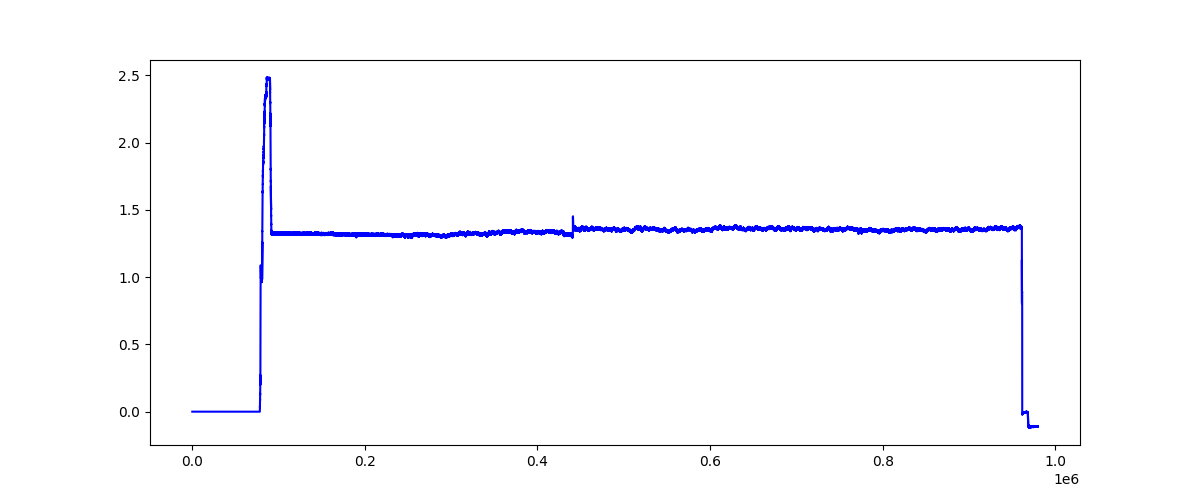

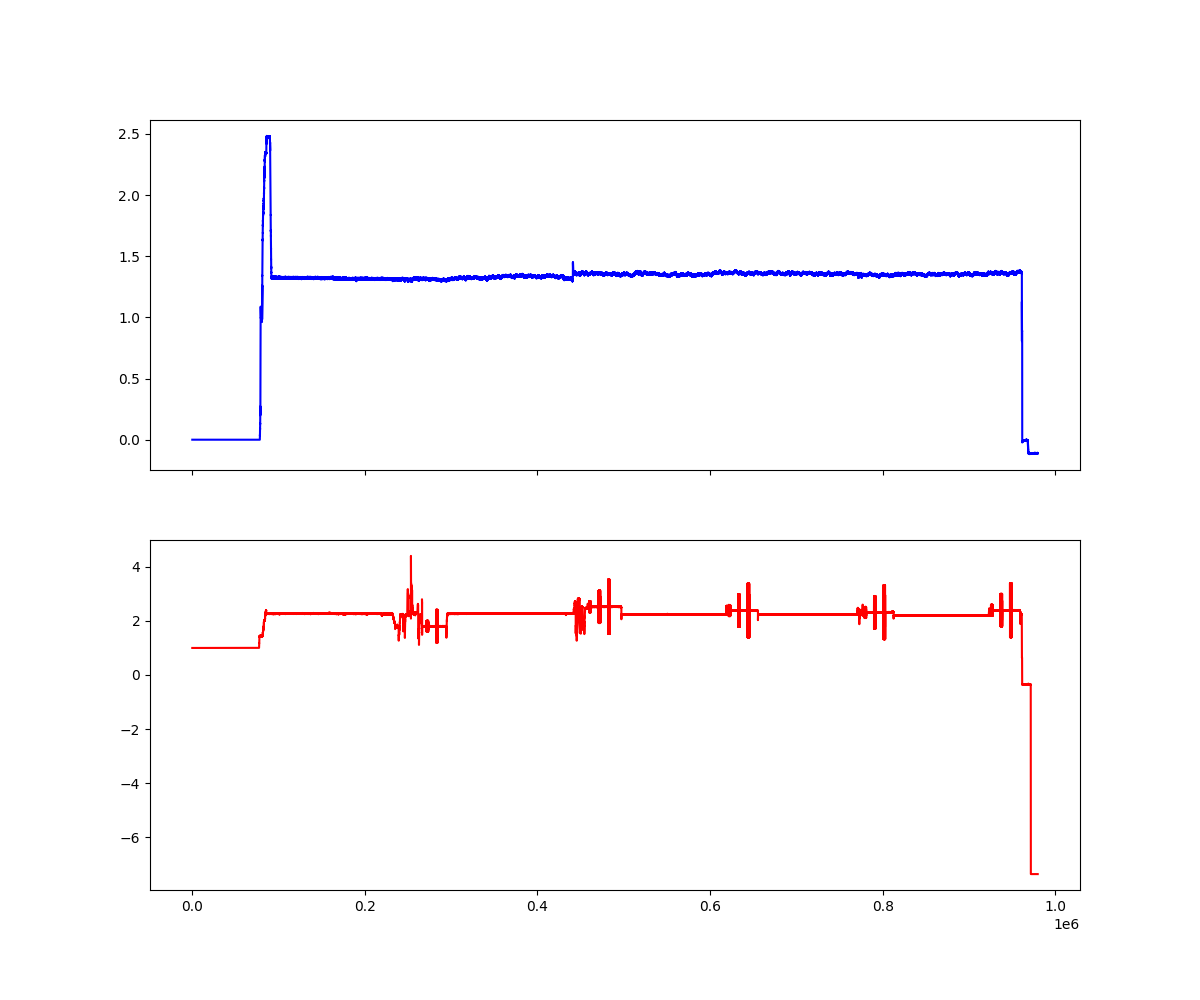

In [9]:
# pl('ppa press', 'ppb press', 0, -1)

In [15]:
data.drop(['Vert DCDT', 'Vert LOAD', 'ppb press', 'ppb disp'], axis=1, inplace=True)

In [16]:
with h5.File("p5720_r.hdf5", "w") as f:
    for chanName in data.keys():
        f.create_dataset(chanName, data=data[chanName])